This tutorial trains a 3D densenet for lung lesion classification from CT image patches.

The goal is to demonstrate MONAI's class activation mapping functions for visualising the classification models.

For the demo data:
- Please see the `bbox_gen.py` script for generating the patch classification data from MSD task06_lung (available via `monai.apps.DecathlonDataset`).
- Alternatively, the patch dataset (~130MB) is available for direct downloading at: https://drive.google.com/drive/folders/1pQdzdkkC9c2GOblLgpGlG3vxsSK9NtDx

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/modules/interpretability/class_lung_lesion.ipynb)

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"

In [2]:
import glob
import os
import random
import tempfile

import matplotlib.pyplot as plt
import monai
import numpy as np
import torch
from IPython.display import clear_output
from monai.networks.utils import eval_mode
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    RandFlipd,
    RandRotate90d,
    RandSpatialCropd,
    Resized,
    ScaleIntensityRanged,
    EnsureTyped,
)
from monai.visualize import plot_2d_or_3d_image
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from torch.utils.tensorboard import SummaryWriter

monai.config.print_config()
random_seed = 42
monai.utils.set_determinism(random_seed)
np.random.seed(random_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MONAI version: 0.4.0+21.g86c43cf.dirty
Numpy version: 1.19.5
Pytorch version: 1.7.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 86c43cf24f57370fbbc12923d09b0f52e7952cb9

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.1.0
Tensorboard version: 2.4.0
gdown version: 3.12.2
TorchVision version: 0.8.2
ITK version: 5.1.2
tqdm version: 4.51.0
lmdb version: 1.0.0
psutil version: 5.8.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = (
    tempfile.mkdtemp() if directory is None else os.path.expanduser(directory)
)

data_path = os.path.join(root_dir, "patch")
url = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/lung_lesion_patches.tar.gz"
monai.apps.download_and_extract(url, output_dir=data_path)

In [4]:
lesion = glob.glob(os.path.join(data_path, "lesion_*"))
non_lesion = glob.glob(os.path.join(data_path, "norm_*"))
# optionally make sure there's 50:50 lesion vs non-lesion
balance_classes = True
if balance_classes:
    print(
        f"Before balance -- Num lesion: {len(lesion)},"
        f" num non-lesion: {len(non_lesion)}"
    )
    num_to_keep = min(len(lesion), len(non_lesion))
    lesion = lesion[:num_to_keep]
    non_lesion = non_lesion[:num_to_keep]
    print(
        f"After balance -- Num lesion: {len(lesion)},"
        f" num non-lesion: {len(non_lesion)}"
    )
labels = np.asarray(
    [[0.0, 1.0]] * len(lesion) + [[1.0, 0.0]] * len(non_lesion)
)

all_files = [
    {"image": img, "label": label}
    for img, label in zip(lesion + non_lesion, labels)
]
random.shuffle(all_files)
print(f"total items: {len(all_files)}")

Before balance -- Num lesion: 64, num non-lesion: 187
After balance -- Num lesion: 64, num non-lesion: 64
total items: 128


Split the data into 80% training and 20% validation


In [5]:
train_frac, val_frac = 0.8, 0.2
n_train = int(train_frac * len(all_files)) + 1
n_val = min(len(all_files) - n_train, int(val_frac * len(all_files)))

train_files, val_files = all_files[:n_train], all_files[-n_val:]
train_labels = [data["label"] for data in train_files]
print(f"total train: {len(train_files)}")

val_labels = [data["label"] for data in val_files]
n_neg, n_pos = np.sum(np.asarray(val_labels) == 0), np.sum(
    np.asarray(val_labels) == 1
)
print(f"total valid: {len(val_labels)}")

total train: 103
total valid: 25


Create the data loaders. These loaders will be used for both training/validation, as well as visualisations.

In [6]:
# Define transforms for image
win_size = (196, 196, 144)
train_transforms = Compose(
    [
        LoadImaged("image"),
        AddChanneld("image"),
        ScaleIntensityRanged(
            "image",
            a_min=-1000.0,
            a_max=500.0,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        RandFlipd("image", spatial_axis=0, prob=0.5),
        RandFlipd("image", spatial_axis=1, prob=0.5),
        RandFlipd("image", spatial_axis=2, prob=0.5),
        RandSpatialCropd("image", roi_size=(64, 64, 40)),
        Resized("image", spatial_size=win_size, mode="trilinear", align_corners=True),
        RandRotate90d("image", prob=0.5, spatial_axes=[0, 1]),
        EnsureTyped("image"),
    ]
)
val_transforms = Compose(
    [
        LoadImaged("image"),
        AddChanneld("image"),
        ScaleIntensityRanged(
            "image",
            a_min=-1000.0,
            a_max=500.0,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        Resized("image", spatial_size=win_size, mode="trilinear", align_corners=True),
        EnsureTyped(("image", "label")),
    ]
)

persistent_cache = os.path.join(root_dir, "persistent_cache")
train_ds = monai.data.PersistentDataset(
    data=train_files, transform=train_transforms, cache_dir=persistent_cache
)
train_loader = monai.data.DataLoader(
    train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=True
)
val_ds = monai.data.PersistentDataset(
    data=val_files, transform=val_transforms, cache_dir=persistent_cache
)
val_loader = monai.data.DataLoader(
    val_ds, batch_size=2, num_workers=2, pin_memory=True
)

Start the model, loss function, and optimizer.

In [7]:
model = monai.networks.nets.DenseNet121(
    spatial_dims=3, in_channels=1, out_channels=2
).to(device)
bce = torch.nn.BCEWithLogitsLoss()


def criterion(logits, target):
    return bce(logits.view(-1), target.view(-1))


optimizer = torch.optim.Adam(model.parameters(), 1e-5)

Run training iterations.

In [8]:

# start training
val_interval = 1
max_epochs = 100
best_metric = best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
scaler = torch.cuda.amp.GradScaler()
for epoch in range(max_epochs):
    clear_output()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = step = 0
    for batch_data in train_loader:
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs.float(), labels.float())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        if step % 50 == 0:
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        step += 1
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        with eval_mode(model):
            num_correct = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = model(val_images)
                value = torch.eq(
                    val_outputs.argmax(dim=1), val_labels.argmax(dim=1)
                )
                metric_count += len(value)
                num_correct += value.sum().item()
            metric = num_correct / metric_count
            metric_values.append(metric)
            if metric >= best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(
                    model.state_dict(),
                    "best_metric_model_classification3d_array.pth",
                )
            print(
                f"current epoch: {epoch + 1} current accuracy: {metric:.4f}"
                f" best accuracy: {best_metric:.4f}"
                f" at epoch {best_metric_epoch}"
            )
print(
    f"train completed, best_metric: {best_metric:.4f} at"
    f" epoch: {best_metric_epoch}"
)

----------
epoch 100/100
0/51, train_loss: 0.0902
50/51, train_loss: 0.0978
epoch 100 average loss: 0.2973
current epoch: 100 current accuracy: 0.8000 best accuracy: 0.9200 at epoch 18
train completed, best_metric: 0.9200 at epoch: 18


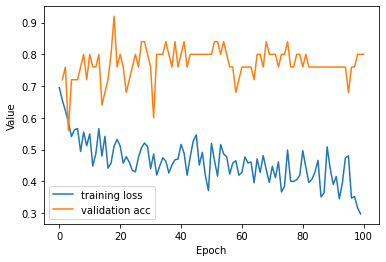

In [9]:
plt.plot(epoch_loss_values, label="training loss")
val_epochs = np.linspace(
    1, max_epochs, np.floor(max_epochs / val_interval).astype(np.int32)
)
plt.plot(val_epochs, metric_values, label="validation acc")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Value")

              precision    recall  f1-score   support

  non-lesion       1.00      0.86      0.92        14
      lesion       0.85      1.00      0.92        11

    accuracy                           0.92        25
   macro avg       0.92      0.93      0.92        25
weighted avg       0.93      0.92      0.92        25



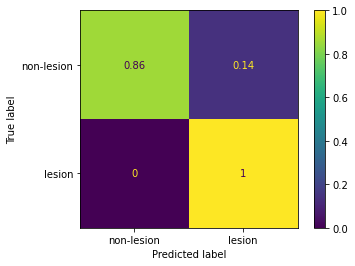

In [10]:
# Reload the best network and display info
model_3d = monai.networks.nets.DenseNet121(
    spatial_dims=3, in_channels=1, out_channels=2
).to(device)
model_3d.load_state_dict(
    torch.load("best_metric_model_classification3d_array.pth")
)
model_3d.eval()

y_pred = torch.tensor([], dtype=torch.float32, device=device)
y = torch.tensor([], dtype=torch.long, device=device)

for val_data in val_loader:
    val_images = val_data["image"].to(device)
    val_labels = val_data["label"].to(device).argmax(dim=1)

    outputs = model_3d(val_images)
    y_pred = torch.cat([y_pred, outputs.argmax(dim=1)], dim=0)
    y = torch.cat([y, val_labels], dim=0)

print(
    classification_report(
        y.cpu().numpy(),
        y_pred.cpu().numpy(),
        target_names=["non-lesion", "lesion"],
    )
)

cm = confusion_matrix(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    normalize="true",
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["non-lesion", "lesion"],
)
disp.plot(ax=plt.subplots(1, 1, facecolor="white")[1])

# Interpretability

Use GradCAM and occlusion sensitivity for network interpretability.

The occlusion sensitivity returns two images: the sensitivity image and the most probable class.

* Sensitivity image -- how the probability of an inferred class changes as the corresponding part of the image is occluded.
    * Big decreases in the probability imply that that region was important in inferring the given class
    * The output is the same as the input, with an extra dimension of size N appended. Here, N is the number of inferred classes. To then see the sensitivity image of the class we're interested (maybe the true class, maybe the predcited class, maybe anything else), we simply do ``im[...,i]``.
* Most probable class -- if that part of the image is covered up, does the predicted class change, and if so, to what? This feature is not used in this notebook.

In [11]:
# cam = monai.visualize.CAM(nn_module=model_3d, target_layers="class_layers.relu", fc_layers="class_layers.out")
cam = monai.visualize.GradCAM(
    nn_module=model_3d, target_layers="class_layers.relu"
)
# cam = monai.visualize.GradCAMpp(nn_module=model_3d, target_layers="class_layers.relu")
print(
    "original feature shape",
    cam.feature_map_size([1, 1] + list(win_size), device),
)
print("upsampled feature shape", [1, 1] + list(win_size))

occ_sens = monai.visualize.OcclusionSensitivity(
    nn_module=model_3d, mask_size=12, n_batch=1, stride=28
)

# For occlusion sensitivity, inference must be run many times. Hence, we can use a
# bounding box to limit it to a 2D plane of interest (z=the_slice) where each of
# the arguments are the min and max for each of the dimensions (in this case CHWD).
the_slice = train_ds[0]["image"].shape[-1] // 2
occ_sens_b_box = [-1, -1, -1, -1, -1, -1, the_slice, the_slice]

original feature shape torch.Size([1, 1, 6, 6, 4])
upsampled feature shape [1, 1, 196, 196, 144]


Computing occlusion sensitivity: 100%|██████████| 49/49 [00:02<00:00, 19.82it/s]


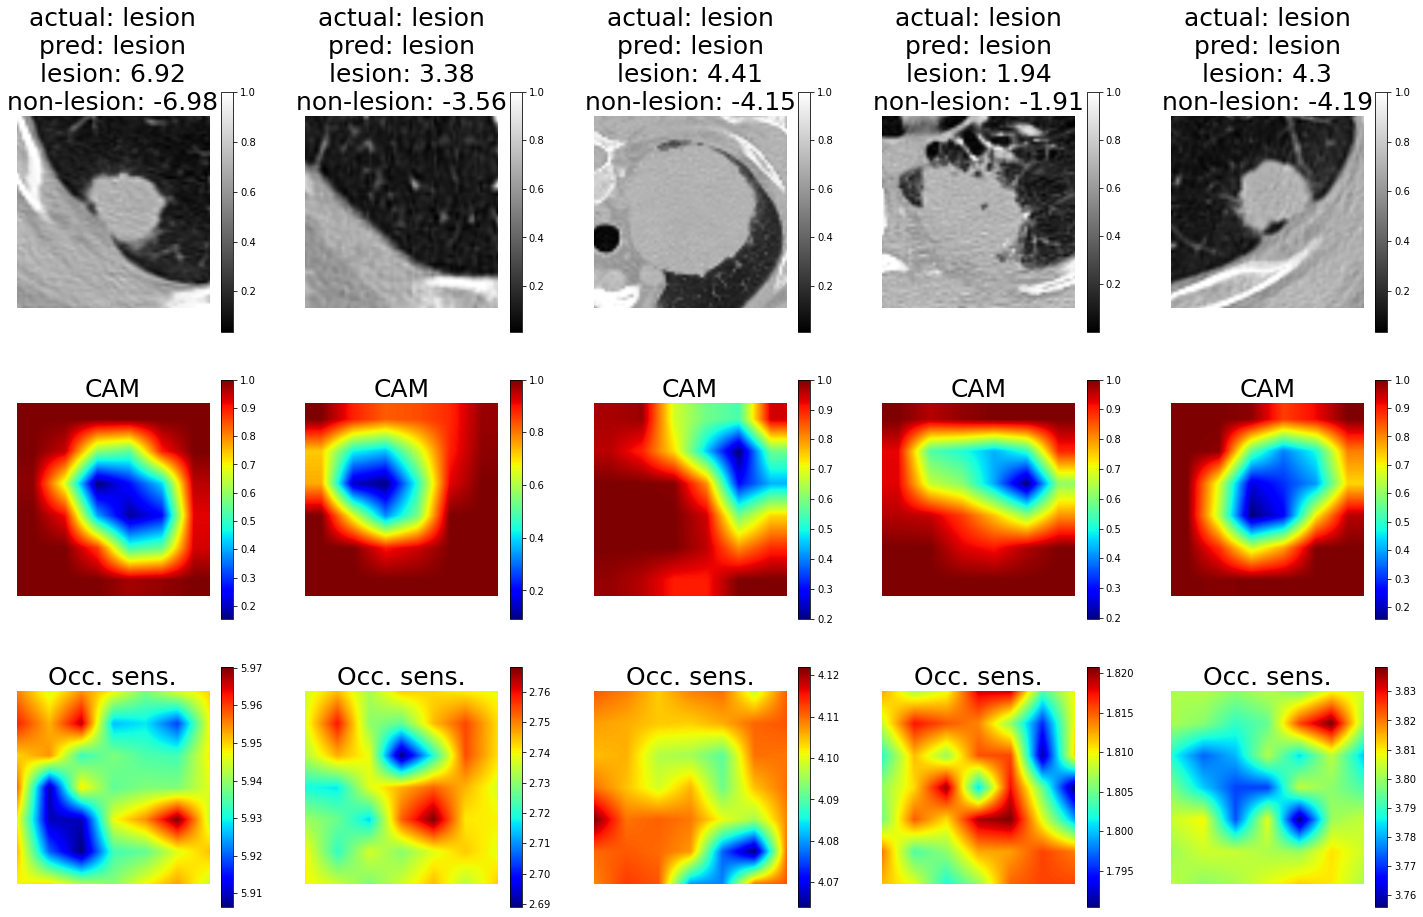

In [12]:
train_transforms.set_random_state(42)
n_examples = 5
subplot_shape = [3, n_examples]
fig, axes = plt.subplots(*subplot_shape, figsize=(25, 15), facecolor="white")
items = np.random.choice(len(train_ds), size=len(train_ds), replace=False)

example = 0
for item in items:

    data = train_ds[
        item
    ]  # this fetches training data with random augmentations
    image, label = data["image"].to(device).unsqueeze(0), data["label"][1]
    y_pred = model_3d(image)
    pred_label = y_pred.argmax(1).item()
    # Only display tumours images
    if label != 1 or label != pred_label:
        continue

    img = image.detach().cpu().numpy()[..., the_slice]

    name = "actual: "
    name += "lesion" if label == 1 else "non-lesion"
    name += "\npred: "
    name += "lesion" if pred_label == 1 else "non-lesion"
    name += f"\nlesion: {y_pred[0,1]:.3}"
    name += f"\nnon-lesion: {y_pred[0,0]:.3}"

    # run CAM
    cam_result = cam(x=image, class_idx=None)
    cam_result = cam_result[..., the_slice]

    # run occlusion
    occ_result, _ = occ_sens(x=image, b_box=occ_sens_b_box)
    occ_result = occ_result[..., pred_label]

    for row, (im, title) in enumerate(
        zip(
            [img, cam_result, occ_result],
            [name, "CAM", "Occ. sens."],
        )
    ):
        cmap = "gray" if row == 0 else "jet"
        ax = axes[row, example]
        if isinstance(im, torch.Tensor):
            im = im.cpu().detach()
        im_show = ax.imshow(im[0][0], cmap=cmap)

        ax.set_title(title, fontsize=25)
        ax.axis("off")
        fig.colorbar(im_show, ax=ax)

    example += 1
    if example == n_examples:
        break

In [13]:

with SummaryWriter(log_dir="logs") as writer:
    plot_2d_or_3d_image(img, step=0, writer=writer, tag="Input")
    plot_2d_or_3d_image(cam_result, step=0, writer=writer, tag="CAM")
    plot_2d_or_3d_image(occ_result, step=0, writer=writer, tag="OccSens")

In [14]:
%load_ext tensorboard
%tensorboard --logdir logs